Предсказываем качество вина с помощью алгоритмов классификации и выбираем из них самый эффективный.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

Загружаем данные

In [ ]:
df = pd.read_csv('winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Проверим тип данных, которые есть в каждой колонке

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Рассмотрим статистические показатели по колнкам датасета

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


Проверим наличие null значений

In [ ]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

Заменим недостающие значения в колонках средними

In [ ]:
for col in df.columns:
  if df[col].isnull().sum() > 0:
    df[col] = df[col].fillna(df[col].mean())

df.isnull().sum().sum()

0

Построим гистограмы распредления значений в колонках

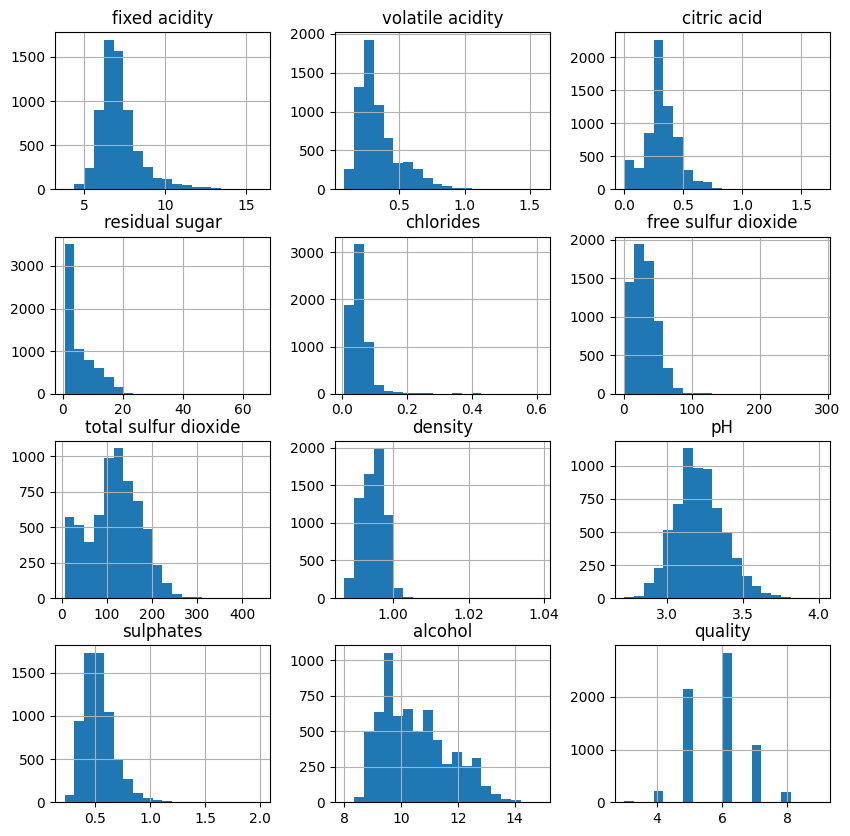

In [ ]:
df.hist(bins=20, figsize=(10, 10))
plt.show()

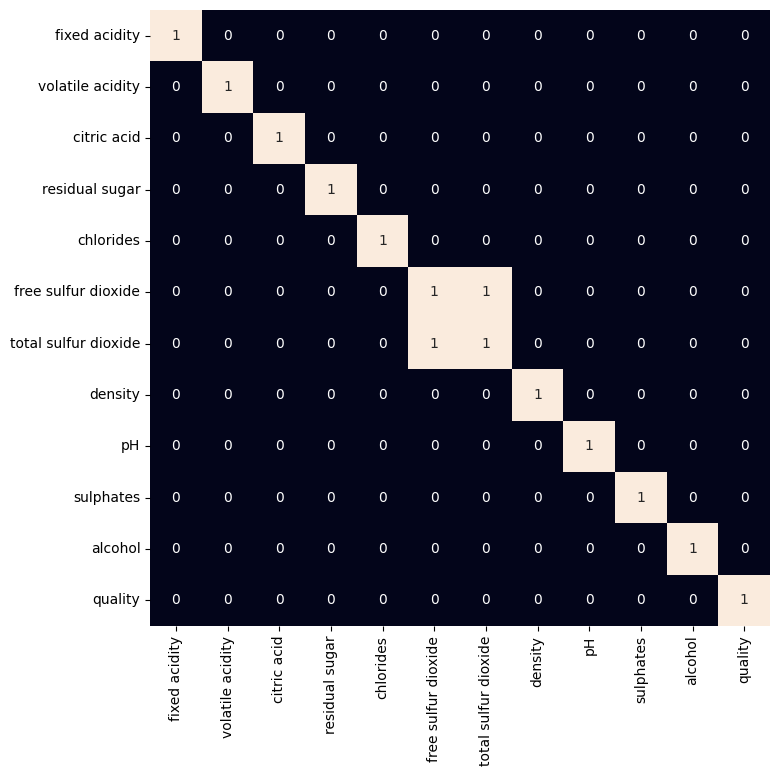

In [ ]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()


 По карте вверху видно, что значения колонок 'total sulphur dioxide' и 'free sulphur dioxide' имеют сильное соотношение, поэтому стоит убрать одно из них.

In [ ]:
df = df.drop('total sulfur dioxide', axis=1)

Посомтрим на колонку с качеством вина 'quality'

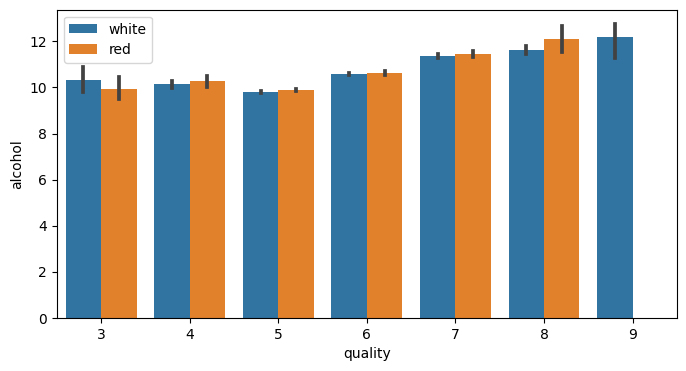

In [ ]:
plt.figure(figsize=(8,4))
sb.barplot(data = df,x="quality",y="alcohol",hue="type")
plt.legend(loc="best")
plt.show()

In [ ]:
df['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [ ]:
df['quality'].mean()

5.818377712790519

На значении 5 видно разделение диапазона значений, таким образом мы можем заменить все значения меньше 5 на 0, а остльным указать 1.

In [ ]:
df['best quality'] = df['quality'].apply(lambda x: 1 if x>=5. else 0)

In [ ]:
df.replace({'white': 1, 'red': 0}, inplace=True)

In [ ]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality,best quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,1.0010,3.00,0.45,8.8,6,1
1,1,6.3,0.30,0.34,1.6,0.049,14.0,0.9940,3.30,0.49,9.5,6,1
2,1,8.1,0.28,0.40,6.9,0.050,30.0,0.9951,3.26,0.44,10.1,6,1
3,1,7.2,0.23,0.32,8.5,0.058,47.0,0.9956,3.19,0.40,9.9,6,1
4,1,7.2,0.23,0.32,8.5,0.058,47.0,0.9956,3.19,0.40,9.9,6,1


Работа с моделями

In [ ]:
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

Разделяем датасет на тестовую и обучающую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=41)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4872, 11) (1625, 11) (4872,) (1625,)


In [ ]:
norm = MinMaxScaler()
x_train = norm.fit_transform(X_train)
x_test = norm.transform(X_test)

Используем 4 алгоритма

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(kernel='rbf'),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

models_report = {'model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1-Score':[]}
for model_name, model in models.items():
  model.fit(x_train, y_train)
  print(f'***************** {model_name} ***************** \n')
  print('Training Accuracy: ', metrics.roc_auc_score(y_train,model.predict(x_train)))
  print('Validation Accuracy: ', metrics.roc_auc_score(y_test, model.predict(x_test)))
  print('Classification Report: ', metrics.classification_report(y_test, model.predict(x_test)))
  print()

  report_model = metrics.classification_report(y_test, model.predict(x_test), output_dict=True)
  models_report['model'].append(model_name)
  models_report['Accuracy'].append(report_model['accuracy'])
  models_report['Precision'].append(report_model['weighted avg']['precision'])
  models_report['Recall'].append(report_model['weighted avg']['recall'])
  models_report['F1-Score'].append(report_model['weighted avg']['f1-score'])


***************** LogisticRegression ***************** 

Training Accuracy:  0.5028571428571429
Validation Accuracy:  0.5
Classification Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.96      1.00      0.98      1554

    accuracy                           0.96      1625
   macro avg       0.48      0.50      0.49      1625
weighted avg       0.91      0.96      0.93      1625


***************** SVC ***************** 

Training Accuracy:  0.5
Validation Accuracy:  0.5
Classification Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.96      1.00      0.98      1554

    accuracy                           0.96      1625
   macro avg       0.48      0.50      0.49      1625
weighted avg       0.91      0.96      0.93      1625


***************** DecisionTreeClassifier ***************** 

Training Accuracy:  1

Составляем отчет по моделям

In [ ]:
models_report_show = pd.DataFrame(models_report)

models_report_show.round(2).sort_values(by=['Accuracy', 'Precision'],ascending=False)

,model,Accuracy,Precision,Recall,F1-Score
3,RandomForestClassifier,0.96,0.96,0.96,0.95
0,LogisticRegression,0.96,0.91,0.96,0.93
1,SVC,0.96,0.91,0.96,0.93
2,DecisionTreeClassifier,0.95,0.94,0.95,0.94
